In [8]:
import numpy as np
import pandas as pd
import pymongo
from pymongo import MongoClient
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import pprint
import statsmodels.api as sm
import src.sentiment as snt
from data.get_data import get_download_links

from datetime import datetime
import boto3
import os
import re
import time
import subprocess

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
links_df = get_download_links()
links_df.head()

,month,link,downloaded,size_in_bytes,comment_count
0,2005-12,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
1,2006-01,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
2,2006-02,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
3,2006-03,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
4,2006-04,https://files.pushshift.io/reddit/comments/RC_...,False,0,0


In [3]:
client = MongoClient()
db = client['myreddit']
posts_all = db['posts_all']

yearmonths = sorted(posts_all.distinct('yearmonth'))

In [7]:
posts_all.find_one()

{'_id': ObjectId('5e554d246960e0b4e8de88fd'),
 'link_id': '2cnnc',
 'title': 'Smashing interview by Ron Paul on FOX!  "Just come home"',
 'score': 61,
 'is_self': False,
 'datetime': 1186379408.0,
 'sub': 'politics',
 'permalink': '/r/politics/comments/2cnnc/smashing_interview_by_ron_paul_on_fox_just_come/',
 'yearmonth': '2007-08'}

In [104]:
def posts_containing_phrase(phrase):
    pipe = [{'$match':{'title': re.compile(phrase, re.IGNORECASE),
                       'sub': 'politics'}}, 
            {'$group': {'_id': '$yearmonth', 
                        'total': {'$sum': '$score'}, 
                        'count': {'$sum': 1}}}, 
            {'$sort': {'_id': 1}}]
    cursor = posts_all.aggregate(pipeline=pipe)
    
    df = pd.DataFrame(list(cursor)).rename({'_id': 'yearmonth', 'total': 'total score'}, axis='columns')\
                                   .set_index('yearmonth')
    score_avg = df['total score'].mean()
    count_avg = df['count'].mean()
    df['normalized score'] = df['total score'].apply(lambda x: x/score_avg)
    df['normalized count'] = df['count'].apply(lambda x: x/count_avg)
    
    return df

In [62]:
def remove_before_null(stats_dict):
    delete = False
    for k, v in reversed(sorted(stats_dict.items())):
        if (v is None) or (v['avg_wght_pol'] is None):
            delete = True

        if delete:
            del stats_dict[k]
    
    return stats_dict

In [105]:
rp_df = posts_containing_phrase('ron paul')

In [63]:
# rp_df[['normalized count', 'normalized score']].plot(figsize=(14, 6))

In [107]:
sanders_df = posts_containing_phrase('sanders')

In [64]:
# sanders_df[['normalized count', 'normalized score']].plot(figsize=(14, 6))

In [53]:
bernie_sentiment_vader = {}
for idx in range(len(yearmonths) - 1):
    results = snt.monthly_stats_by_topic(yearmonths[idx:idx+2], 'politics', phrase='bernie')
    bernie_sentiment_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


In [58]:
trump_sentiment_vader = {}
for idx in range(len(yearmonths) - 1):
    results = snt.monthly_stats_by_topic(yearmonths[idx:idx+2], 'politics', phrase='trump')
    trump_sentiment_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


In [68]:
obama_sentiment_vader = {}
for idx in range(len(yearmonths) - 1):
    results = snt.monthly_stats_by_topic(yearmonths[idx:idx+2], 'politics', phrase='obama')
    obama_sentiment_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


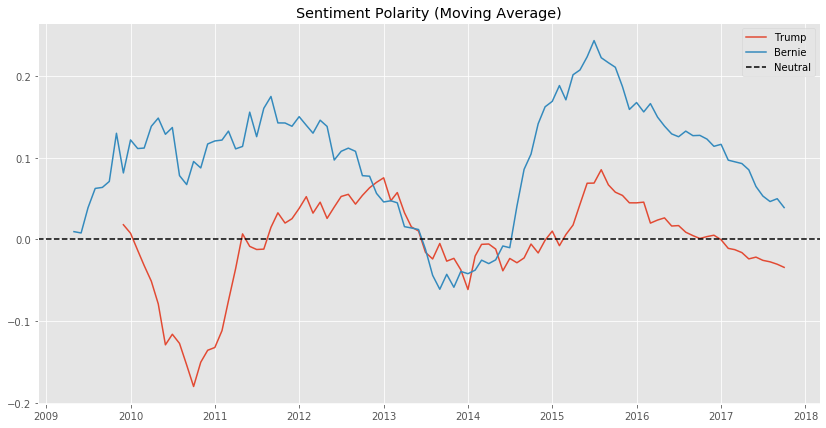

In [94]:
data_dicts = [(remove_before_null(trump_sentiment_vader), 'Trump'),
              (remove_before_null(bernie_sentiment_vader), 'Bernie')]#,
#               (remove_before_null(obama_sentiment_vader), 'Obama')]

N = 12
fig, axes = plt.subplots(1, 1, figsize=(14, 7))

years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

for data_dict, topic in data_dicts:
    dates = [datetime.strptime(k, '%Y-%m').date() for k, _ in sorted(data_dict.items())]
    awp = [v['avg_wght_pol'] for _, v in sorted(data_dict.items())]
    awp_ma = np.convolve(np.array(awp), np.ones((N,))/N, mode='valid')

    axes.plot(dates[N-1:], awp_ma, label=topic)
    axes.set_title('Sentiment Polarity (Moving Average)')

axes.axhline(0, c='k', linestyle='--', label='Neutral')
_ = plt.legend()

In [82]:
repub_sentiment_vader = {}
for idx in range(len(yearmonths) - 1):
    results = snt.monthly_stats_by_topic(yearmonths[idx:idx+2], 'politics', phrase='republican')
    repub_sentiment_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


In [83]:
dem_sentiment_vader = {}
for idx in range(len(yearmonths) - 1):
    results = snt.monthly_stats_by_topic(yearmonths[idx:idx+2], 'politics', phrase='democrat')
    dem_sentiment_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


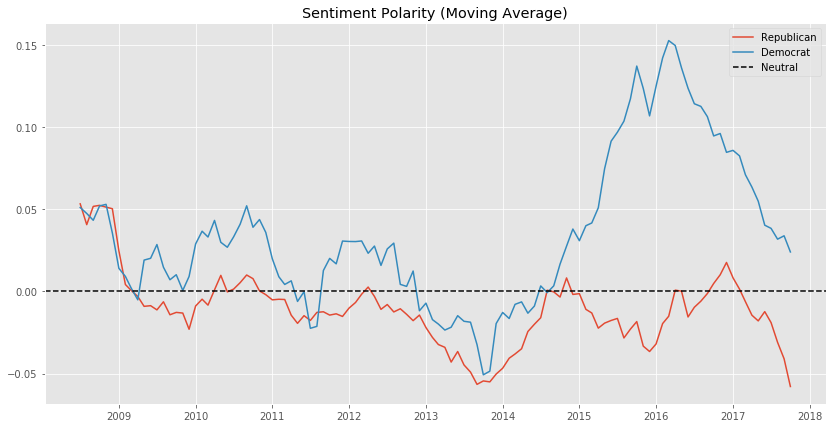

In [93]:
data_dicts = [(remove_before_null(repub_sentiment_vader), 'Republican'),
              (remove_before_null(dem_sentiment_vader), 'Democrat')]

N = 12
fig, axes = plt.subplots(1, 1, figsize=(14, 7))

years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

for data_dict, topic in data_dicts:
    dates = [datetime.strptime(k, '%Y-%m').date() for k, _ in sorted(data_dict.items())]
    awp = [v['avg_wght_pol'] for _, v in sorted(data_dict.items())]
    awp_ma = np.convolve(np.array(awp), np.ones((N,))/N, mode='valid')

    axes.plot(dates[N-1:], awp_ma, label=topic)
    axes.set_title('Sentiment Polarity (Moving Average)')

axes.axhline(0, c='k', linestyle='--', label='Neutral')
_ = plt.legend()

In [95]:
ubi_sentiment_vader = {}
for idx in range(len(yearmonths) - 1):
    results = snt.monthly_stats_by_topic(yearmonths[idx:idx+2], 'politics', phrase='ubi')
    ubi_sentiment_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


In [97]:
nsa_sentiment_vader = {}
for idx in range(len(yearmonths) - 1):
    results = snt.monthly_stats_by_topic(yearmonths[idx:idx+2], 'politics', phrase='nsa')
    nsa_sentiment_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


In [100]:
flint_sentiment_vader = {}
for idx in range(len(yearmonths) - 1):
    results = snt.monthly_stats_by_topic(yearmonths[idx:idx+2], 'politics', phrase='flint')
    flint_sentiment_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


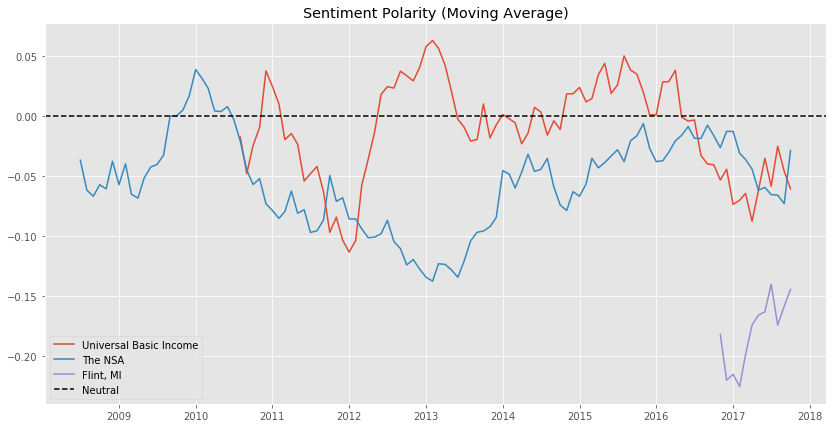

In [102]:
data_dicts = [(remove_before_null(ubi_sentiment_vader), 'Universal Basic Income'),
              (remove_before_null(nsa_sentiment_vader), 'The NSA'),
              (remove_before_null(flint_sentiment_vader), 'Flint, MI')]

N = 12
fig, axes = plt.subplots(1, 1, figsize=(14, 7))

years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

for data_dict, topic in data_dicts:
    dates = [datetime.strptime(k, '%Y-%m').date() for k, _ in sorted(data_dict.items())]
    awp = [v['avg_wght_pol'] for _, v in sorted(data_dict.items())]
    awp_ma = np.convolve(np.array(awp), np.ones((N,))/N, mode='valid')

    axes.plot(dates[N-1:], awp_ma, label=topic)
    axes.set_title('Sentiment Polarity (Moving Average)')

sct_data = data_dicts[2][0]
axes.scatter(

axes.axhline(0, c='k', linestyle='--', label='Neutral')
_ = plt.legend()

113


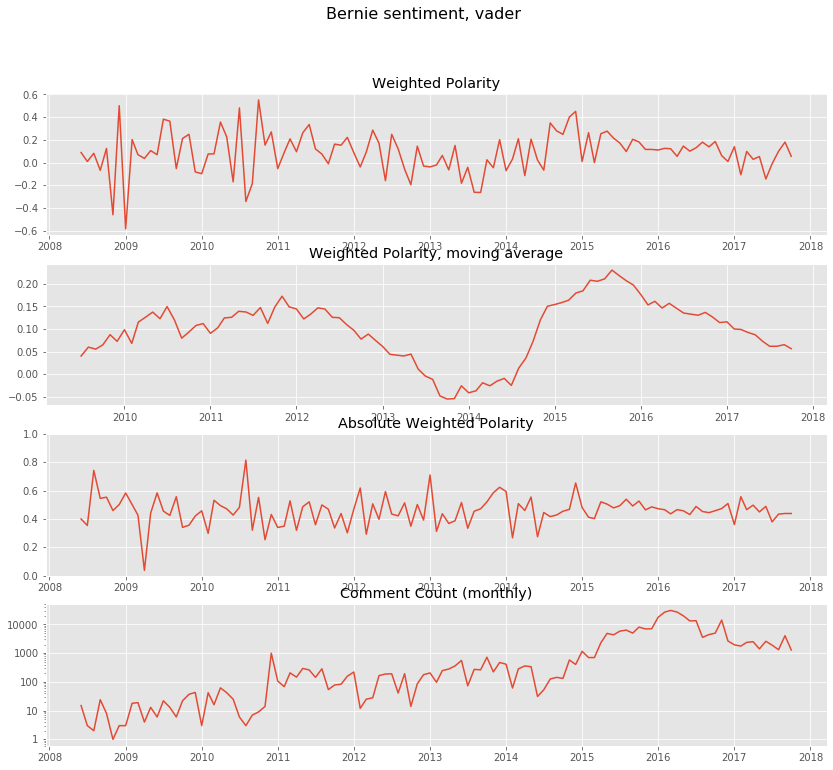

In [61]:
data_dict = remove_before_null(bernie_sentiment_vader)
# pprint.pprint(data_dict)
N = 14

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

fig.suptitle('Bernie sentiment, vader', fontsize=16)
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

dates = [datetime.strptime(k, '%Y-%m').date() for k, _ in sorted(data_dict.items())]
awp = [v['avg_wght_pol'] for _, v in sorted(data_dict.items())]
awp_ma = np.convolve(np.array(awp), np.ones((N,))/N, mode='valid')
aawp = [v['avg_abs_wght_pol'] for _, v in sorted(data_dict.items())]
aap = [v['avg_abs_pol'] for _, v in sorted(data_dict.items())]
ccnt = [v['comment_count'] for _, v in sorted(data_dict.items())]
awc = [v['avg_wordcount'] for _, v in sorted(data_dict.items())]

axes[0].plot(dates, awp)
# axes[0].set_ylim([0, 1])
axes[0].set_title('Weighted Polarity')

axes[1].plot(dates[N-1:], awp_ma)
axes[1].set_title('Weighted Polarity, moving average')

axes[2].plot(dates, aawp)
# aawp_trendline, params = make_trend_line(aawp)
# axes[0].plot(dates, aawp_trendline)
axes[2].set_ylim([0, 1])
axes[2].set_title('Absolute Weighted Polarity')

#     axes[1].plot(dates, aap)
#     axes[1].set_title('Absolute Comment Polarity')

axes[3].plot(dates, ccnt)
axes[3].set_title('Comment Count (monthly)')

axes[3].set_yscale('log')
axes[3].yaxis.set_major_formatter(ScalarFormatter())

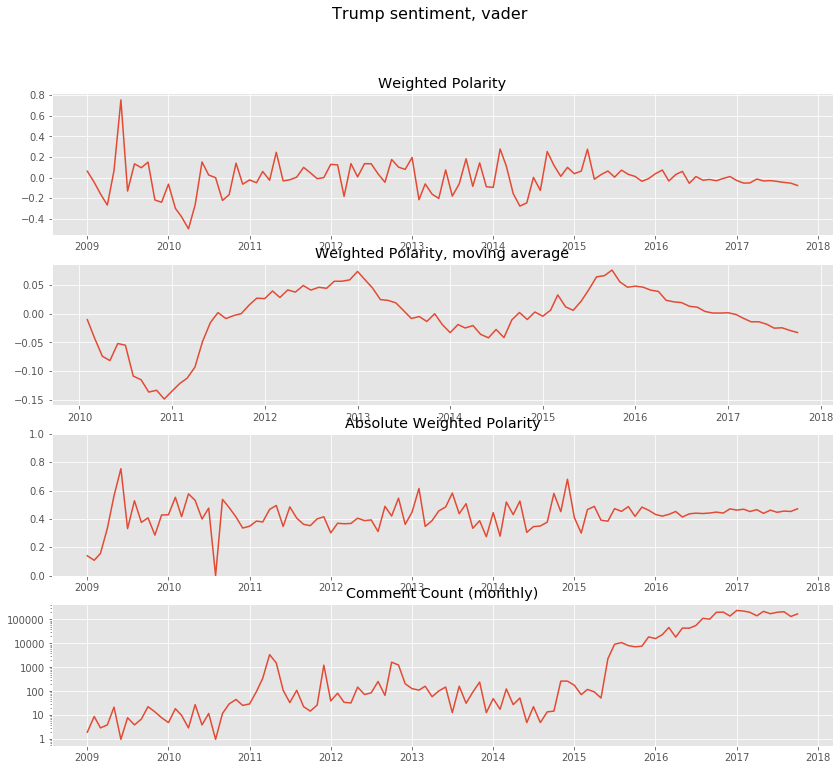

In [65]:
data_dict = remove_before_null(trump_sentiment_vader)
N = 14

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

fig.suptitle('Trump sentiment, vader', fontsize=16)
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

dates = [datetime.strptime(k, '%Y-%m').date() for k, _ in sorted(data_dict.items())]
awp = [v['avg_wght_pol'] for _, v in sorted(data_dict.items())]
awp_ma = np.convolve(np.array(awp), np.ones((N,))/N, mode='valid')
aawp = [v['avg_abs_wght_pol'] for _, v in sorted(data_dict.items())]
aap = [v['avg_abs_pol'] for _, v in sorted(data_dict.items())]
ccnt = [v['comment_count'] for _, v in sorted(data_dict.items())]
awc = [v['avg_wordcount'] for _, v in sorted(data_dict.items())]

axes[0].plot(dates, awp)
# axes[0].set_ylim([0, 1])
axes[0].set_title('Weighted Polarity')

axes[1].plot(dates[N-1:], awp_ma)
axes[1].set_title('Weighted Polarity, moving average')

axes[2].plot(dates, aawp)
# aawp_trendline, params = make_trend_line(aawp)
# axes[0].plot(dates, aawp_trendline)
axes[2].set_ylim([0, 1])
axes[2].set_title('Absolute Weighted Polarity')

#     axes[1].plot(dates, aap)
#     axes[1].set_title('Absolute Comment Polarity')

axes[3].plot(dates, ccnt)
axes[3].set_title('Comment Count (monthly)')

axes[3].set_yscale('log')
axes[3].yaxis.set_major_formatter(ScalarFormatter())

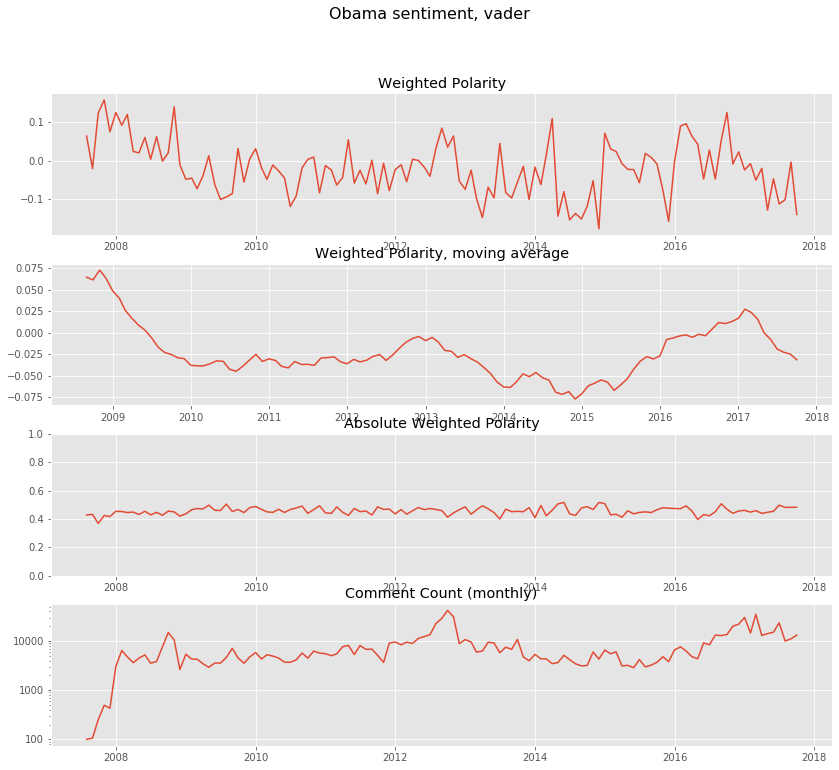

In [66]:
data_dict = remove_before_null(obama_sentiment_vader)
N = 14

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

fig.suptitle('Obama sentiment, vader', fontsize=16)
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

dates = [datetime.strptime(k, '%Y-%m').date() for k, _ in sorted(data_dict.items())]
awp = [v['avg_wght_pol'] for _, v in sorted(data_dict.items())]
awp_ma = np.convolve(np.array(awp), np.ones((N,))/N, mode='valid')
aawp = [v['avg_abs_wght_pol'] for _, v in sorted(data_dict.items())]
aap = [v['avg_abs_pol'] for _, v in sorted(data_dict.items())]
ccnt = [v['comment_count'] for _, v in sorted(data_dict.items())]
awc = [v['avg_wordcount'] for _, v in sorted(data_dict.items())]

axes[0].plot(dates, awp)
# axes[0].set_ylim([0, 1])
axes[0].set_title('Weighted Polarity')

axes[1].plot(dates[N-1:], awp_ma)
axes[1].set_title('Weighted Polarity, moving average')

axes[2].plot(dates, aawp)
# aawp_trendline, params = make_trend_line(aawp)
# axes[0].plot(dates, aawp_trendline)
axes[2].set_ylim([0, 1])
axes[2].set_title('Absolute Weighted Polarity')

#     axes[1].plot(dates, aap)
#     axes[1].set_title('Absolute Comment Polarity')

axes[3].plot(dates, ccnt)
axes[3].set_title('Comment Count (monthly)')

axes[3].set_yscale('log')
axes[3].yaxis.set_major_formatter(ScalarFormatter())